In [41]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
import json

from collections import OrderedDict
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm as gauss

import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd
import random

import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys

import os
import sys
sys.path.insert(0, '../')
from scripts import build_vae, decode_smiles, generate_structures, my_colors, MoleculeVAE

def generate_structures(vae, smi, char_to_index, limit=1e4, write=False):
    """
    Quick and Dirty: 
    Use this VAE, this smiles string, and this char_to_index
    dictionary to randomly generate structures at random temperatures
    """
    rdkit_mols = []
    temps = []
    iterations = []
    iteration = limit_counter = 0
    while True:
        iteration += 1
        limit_counter += 1
        t = random.random()*2
        candidate = decode_smiles(vae, smi, char_to_index, temp=t).split(" ")[0]
        try:
            sampled = Chem.MolFromSmiles(candidate)
            cation = Chem.AddHs(sampled)
            Chem.EmbedMolecule(cation, Chem.ETKDG())
            Chem.UFFOptimizeMolecule(cation)
            cation = Chem.RemoveHs(cation)
            candidate = Chem.MolToSmiles(cation)
            if candidate not in rdkit_mols:
                temps.append(t)
                iterations.append(iteration)
                rdkit_mols.append(candidate) 
                limit_counter = 0
                df = pd.DataFrame([rdkit_mols,temps,iterations]).T
                df.columns = ['smiles', 'temperature', 'iteration']
                print(df)
        except:
            pass
        if limit_counter > limit:
            break
        if write:
            df = pd.DataFrame([rdkit_mols,temps,iterations]).T
            df.columns = ['smiles', 'temperature', 'iteration']
            pd.DataFrame.to_csv(df, path_or_buf='{}.csv'.format(write), index=False)
    return df

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))
        
def one_hot(smi, char_to_index):
    test_smi = smi
    smile_max_length=51
    char_set = set(char_to_index.keys())
    test_smi = pad_smiles(test_smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(list(char_set))), dtype=np.bool)
    for t, char in enumerate(test_smi):
        Z[0, t, char_to_index[char]] = 1
    return Z

from numpy import *
from numpy.linalg import norm

def slerp(p0, p1, t):
        omega = arccos(dot(p0/norm(p0), p1/norm(p1)))
        so = sin(omega)
        return sin((1.0-t)*omega) / so * p0 + sin(t*omega)/so * p1

def interpolate_structures(vae, ps, char_to_index, limit=1e4, write=False, temp=0.5):
    """
    Quick and Dirty: 
    Use this VAE, these interpolations of embeded z's, and this char_to_index
    dictionary to randomly generate structures at temp
    """
    rdkit_mols = []
    temps = []
    iterations = []
    iteration = limit_counter = 0
    df = pd.DataFrame()
    for p in ps:
        while True:
            iteration += 1
            limit_counter += 1
            t = temp
            candidate = decode_latent(chemvae, p.reshape(1,292), char_to_index, temp=t)
            try:
                sampled = Chem.MolFromSmiles(candidate)
                cation = Chem.AddHs(sampled)
                Chem.EmbedMolecule(cation, Chem.ETKDG())
                Chem.UFFOptimizeMolecule(cation)
                cation = Chem.RemoveHs(cation)
                candidate = Chem.MolToSmiles(cation)
                if candidate not in rdkit_mols:
                    temps.append(t)
                    iterations.append(iteration)
                    rdkit_mols.append(candidate) 
                    limit_counter = 0
                    df = pd.DataFrame([rdkit_mols,temps,iterations]).T
                    df.columns = ['smiles', 'temperature', 'iteration']
                    print(df)
                    print(t)
                    break
            except:
                pass
            if limit_counter > limit:
                break
        if write:
            df = pd.DataFrame([rdkit_mols,temps,iterations]).T
            df.columns = ['smiles', 'temperature', 'iteration']
            pd.DataFrame.to_csv(df, path_or_buf='{}.csv'.format(write), index=False)
    return df
    
def decode_latent(vae, z, char_to_index, temp=0.5, smile_max_length=51):
    """
    vae: variational autoencoder to encode/decode input
    smi: smiles string to encode
    temp: temperature at which to perform sampling
    """
    char_list = list(char_to_index.keys())
    index_to_char = dict((i, c) for i, c in enumerate(char_list))
    string = ""
    for i in vae.decoder.predict(z):
        for j in i:
            index = sample(j, temperature=temp)
            string += index_to_char[index]
    return string

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

#search with single seed data
df1 = pd.read_csv('../scripts/vae_1_structures.csv')
df2 = pd.read_csv('../scripts/vae_2_structures.csv')
df3 = pd.read_csv('../scripts/vae_3_structures.csv')
df4 = pd.read_csv('../scripts/vae_4_structures.csv')
df5 = pd.read_csv('../scripts/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]

#M5 data
weights_file = "../data/{}".format(vae_models[-1])
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
chemvae = MoleculeVAE()
char_set = set(char_to_index.keys())
chemvae.load(char_set, weights_file)

**Interpolation in the latent space (slerp)**

In [9]:
z = []
for smi in cations:
    z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
    z.append(z_i[0])
z = np.array(z)
pca = PCA(n_components=50)
pca.fit_transform(z)

array([[ 1.19658387e+00,  1.61710620e-01, -4.57555532e-01, ...,
        -3.23740877e-02, -8.95795692e-03, -1.65819414e-02],
       [ 1.12649918e+00, -1.19491637e-01,  1.08469166e-01, ...,
        -1.78928338e-02,  3.36365751e-03, -8.19162279e-03],
       [ 1.05775619e+00,  1.68636981e-02, -2.20142946e-01, ...,
         3.74575349e-04, -1.49849849e-02, -2.06523901e-03],
       ...,
       [-2.50896245e-01, -9.59883034e-02, -8.84258449e-01, ...,
        -1.74819194e-02, -2.76061129e-02, -2.71104015e-02],
       [ 6.24375641e-01, -4.51098353e-01, -5.95744491e-01, ...,
         3.21850814e-02, -3.43480939e-03, -6.24713302e-03],
       [-2.07658380e-01, -5.63421905e-01,  3.97092365e-02, ...,
         1.36571308e-03, -8.53356812e-03,  8.14461987e-03]], dtype=float32)

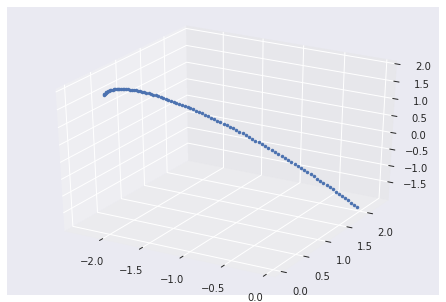

In [10]:
# example of the SLERP
if __name__ == '__main__':
    pA = array([-2.0, 0.0, 2.0])
    pB = array([0.0, 2.0, -2.0])

    ps = array([slerp(pA, pB, t) for t in arange(0.0, 1.0, 0.01)])
    
    f = figure()
    ax = Axes3D(f)
    ax.plot3D(ps[:,0], ps[:,1], ps[:,2], '.')
    show()

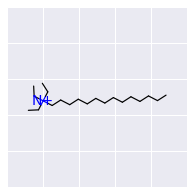

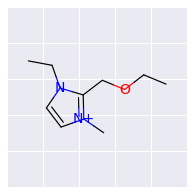

In [11]:
cat1 = z[181]
cat2 = z[242]
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cations[181]), size=(100,100))
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cations[242]), size=(100,100))

In [12]:
# we can interpolate between these molecules...
ps = array([slerp(cat1, cat2, t) for t in arange(0.0, 1.0, 0.1)])
pca.transform(ps)

array([[-1.15339947e+00,  5.81171691e-01, -8.41466710e-02,
        -3.32705528e-01, -1.62150979e-01, -8.18102181e-01,
        -1.37400255e-02, -2.23459080e-01, -2.77367264e-01,
         2.55679101e-01,  4.01119411e-01,  2.42815971e-01,
         4.86693233e-01, -5.46965562e-02,  3.07547867e-01,
        -6.21727481e-03,  1.16920292e-01, -2.08928958e-02,
         2.57477969e-01,  1.06720589e-01, -9.06988010e-02,
        -1.32046670e-01, -1.00238994e-01,  7.73529932e-02,
         1.97924860e-03, -2.13250518e-02,  9.45246685e-03,
        -2.40343809e-02, -1.93989892e-02, -4.86621521e-02,
         1.40707660e-02,  1.16497763e-02, -1.32877706e-03,
         4.95644249e-02, -7.68704526e-03, -7.35713309e-03,
        -1.51571352e-02,  2.09624004e-02,  4.27461183e-03,
        -1.54924253e-03, -2.71054097e-02, -1.87156480e-02,
         6.43109961e-04,  1.03089670e-02,  2.38437112e-02,
         1.32284751e-02, -1.72690041e-02, -2.69654468e-02,
        -1.22340173e-02, -1.37636028e-02],
       [-1.03

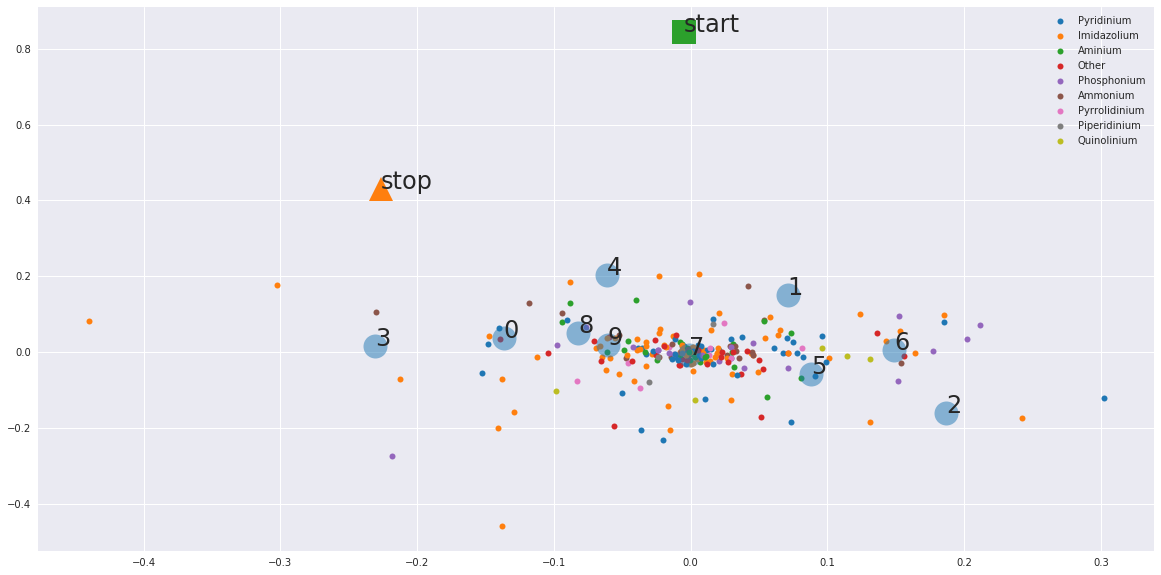

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
for i in range(len(categories)):
    x = np.sum(np.dot(pca.components_[0,i],z[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],z[i,:]))
    if i == 181:
        ax1.plot(x, y, linestyle='', marker='s', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
        ax1.text(x, y, 'start', fontsize=24)
    if i == 242:
        ax1.plot(x, y, linestyle='', marker='^', 
                 color=coldic[categories[i]], markersize=24, label=categories[i])
        ax1.text(x, y, 'stop', fontsize=24)
    ax1.plot(x, y, linestyle='', marker='.', 
             color=coldic[categories[i]], markersize=12, label=categories[i])

# for viewing the PCs of the embeded inerpolations
for i in range(ps.shape[0]):
    x = np.sum(np.dot(pca.components_[0,i],ps[i,:]))
    y = np.sum(np.dot(pca.components_[1,i],ps[i,:]))
    ax1.plot(x, y,
            linestyle='', marker='o', color='tab:blue', markersize=24, alpha=0.5)
    ax1.text(x, y, '{}'.format(i), fontsize=24)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Now lets generate structures between those two points...

In [14]:
df = interpolate_structures(chemvae, ps, char_to_index, limit=1e4, temp=0.25)

                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25        12
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25        12
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        88
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25        12
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        88
2   CCCCCCCCCCCCCC[N+](C)(CC)CC        0.25        89
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25        12
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        88
2   CCCCCCCCCCCCCC[N+](C)(CC)CC        0.25        89
3   C#CCC[N+](CC)CCCCCCCCCCCCCC        0.25       113
0.25
                         smiles temperature iteration
0  CCCCCCCCCCCCCC[N+](CC)(CC)CC        0.25        12
1  CCCCCCCCCCCCCC[C+](CC)(CC)CC        0.25        88
2   CCCCCCCCCCCCCC[N+](C)(CC)CC        0.25        89
3   C#CC

In [107]:
# from a prior run with cation seeds 181 and 242
# df = pd.read_csv('../data/cation_interpolation.csv')

In [15]:
ms = [i for i in df['smiles']]
ms.insert(0, cations[181])
ms.insert(-1, cations[242])

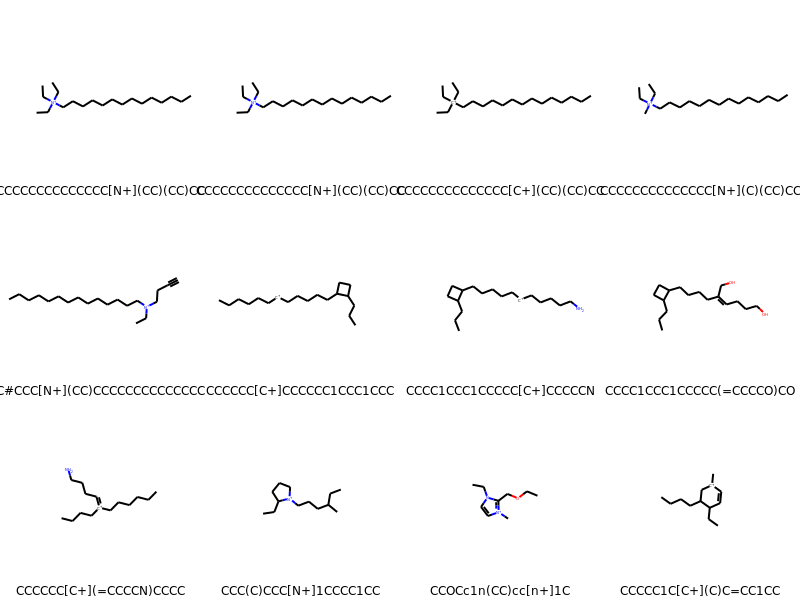

In [16]:
ms = [Chem.MolFromSmiles(smi) for smi in ms]
Draw.MolsToGridImage(ms[:],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

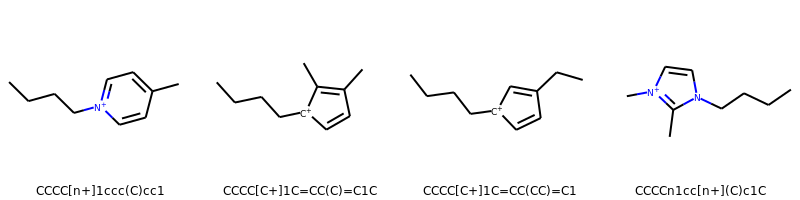

In [17]:
# from a prior run with cation seeds 0 and 2
ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]
Draw.MolsToGridImage(ms[:4],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:4]])

**Visualizing the latent space**

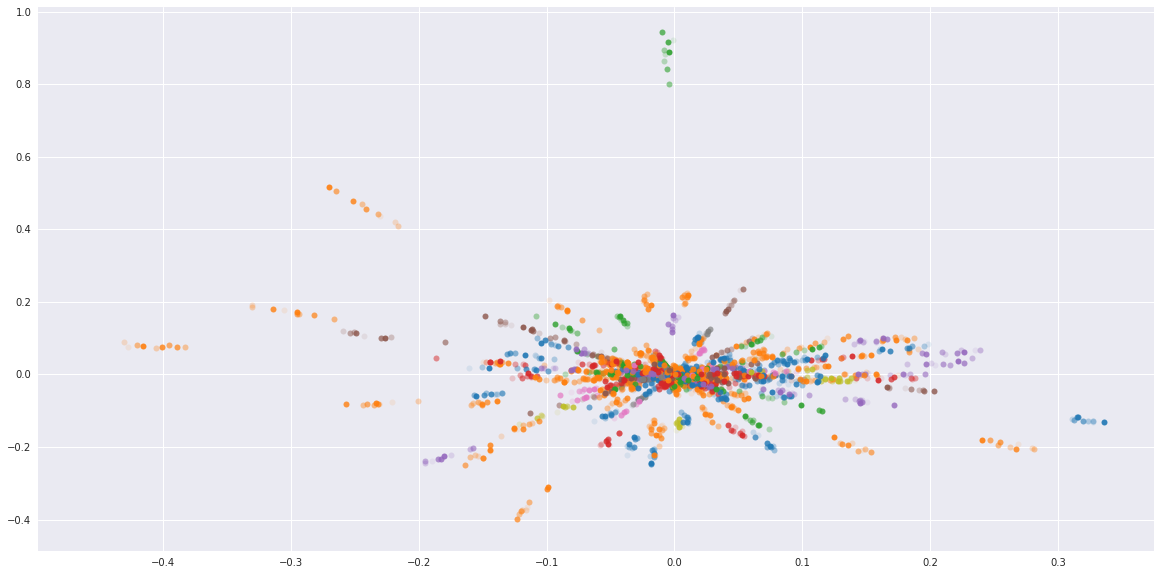

In [18]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
peters_porrige = []
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)
    peters_porrige.append(z)
    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

**we can see the enforced prior in the latent space**

In [57]:
pp[:,:,:].shape

(10, 276, 292)

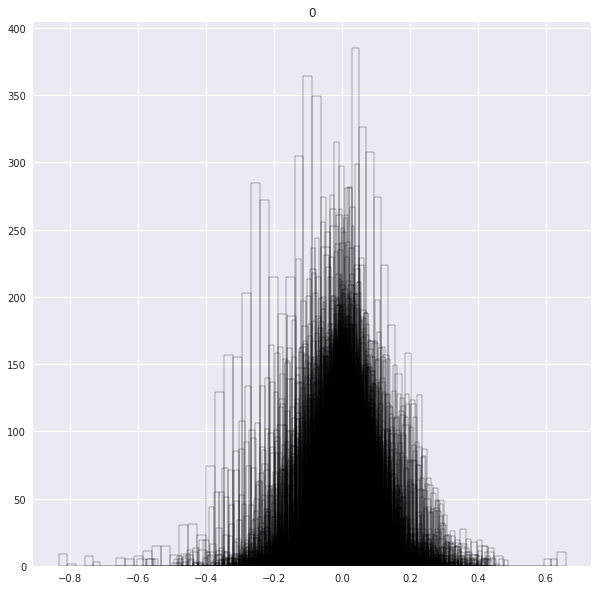

In [22]:
peters_porrige = np.array(peters_porrige)
peters_porrige.shape
pp = peters_porrige
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(100):
    pd.DataFrame(pp[:,:,i].flatten()).hist(bins=50, fill=False, ax=ax)

**compare M1 and M2 latent space distributions**

In [23]:
weights_file = "../data/{}".format(vae_models[0])
chemvae1 = MoleculeVAE()
chemvae1.load(char_set, weights_file)
weights_file = "../data/{}".format(vae_models[1])
chemvae2 = MoleculeVAE()
chemvae2.load(char_set, weights_file)

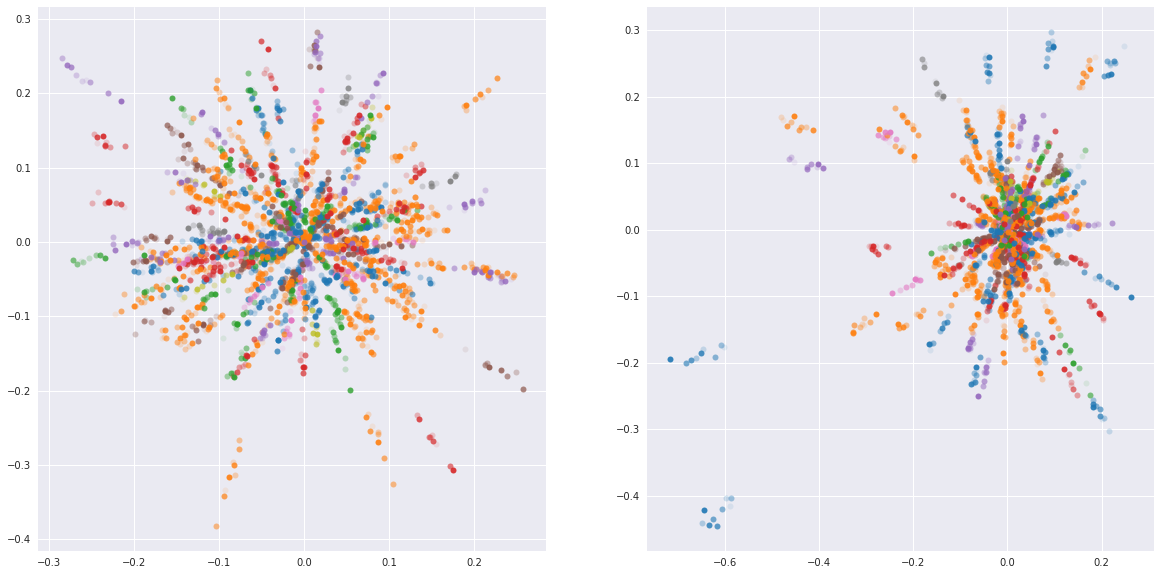

In [27]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
peters_porrige1 = []
peters_porrige2 = []
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae1.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)
    peters_porrige1.append(z)
    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)
        
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae2.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)
    peters_porrige2.append(z)
    for i in range(len(categories)):
        ax2.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

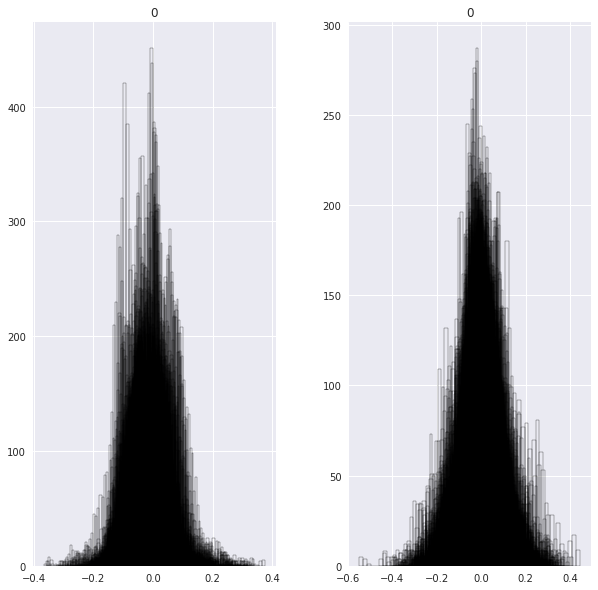

In [52]:
pp1 = np.array(peters_porrige1)
pp2 = np.array(peters_porrige2)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fit1 = []
fit2 = []
for i in range(100):
    pd.DataFrame(pp1[:,:,i].flatten()).hist(bins=50, fill=False, ax=ax1, sharey=True)
    mean,std=gauss.fit(pp1[:,:,i])
    fit1.append([mean,std])
for i in range(100):
    pd.DataFrame(pp2[:,:,i].flatten()).hist(bins=50, fill=False, ax=ax2, sharey=True)
    mean,std=gauss.fit(pp2[:,:,i])
    fit2.append([mean,std])

In [53]:
print(pd.DataFrame(fit1, columns=['means', 'stds']).describe())
print(pd.DataFrame(fit2, columns=['means', 'stds']).describe())

            means        stds
count  100.000000  100.000000
mean    -0.014290    0.045775
std      0.040475    0.011567
min     -0.099939    0.026089
25%     -0.046264    0.036332
50%     -0.016764    0.045674
75%      0.019036    0.053534
max      0.087154    0.084386
            means        stds
count  100.000000  100.000000
mean    -0.001406    0.079865
std      0.029214    0.019847
min     -0.070579    0.048015
25%     -0.020434    0.065784
50%     -0.005127    0.077322
75%      0.019511    0.089618
max      0.066642    0.154991


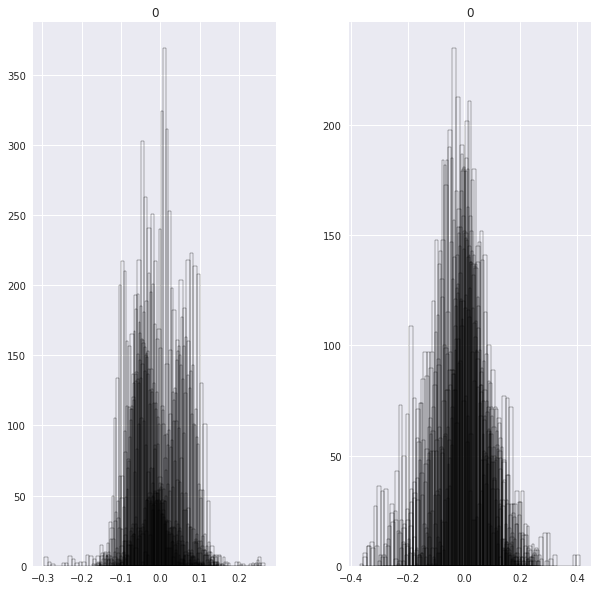

In [54]:
pp1 = np.array(peters_porrige1)
pp2 = np.array(peters_porrige2)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(10):
    pd.DataFrame(pp1[:,:,i].flatten()).hist(bins=50, fill=False, ax=ax1)
for i in range(10):
    pd.DataFrame(pp2[:,:,i].flatten()).hist(bins=50, fill=False, ax=ax2)

**Continuous sampling with single seed**

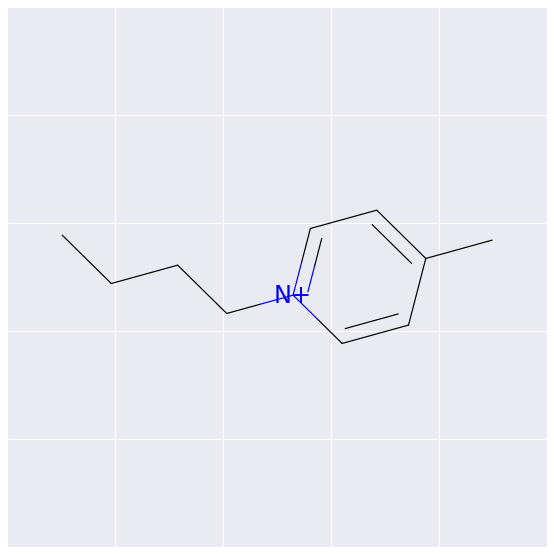

In [118]:
smi = 'CCCC[n+]1ccc(cc1)C'
seed = Chem.MolFromSmiles(smi)
seed_img = Draw.MolToMPL(seed)

Text(0.5,0,'Sanitized Samples')

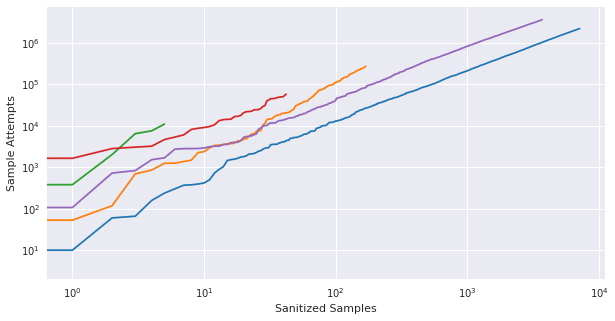

In [119]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
tab = my_colors()
for index, df in enumerate(dfs):
    df['iteration'].plot(label='{}'.format(index+1), ax=ax, loglog=True, color=next(tab))
ax.set_ylabel('Sample Attempts')
ax.set_xlabel('Sanitized Samples')
# plt.legend()

Text(-0.6,-0.5,'Temperature')

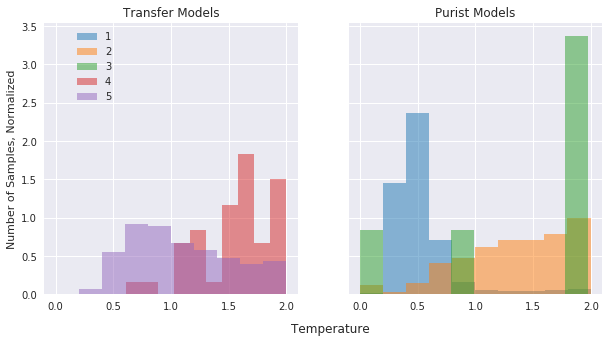

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.6,-0.5,'Temperature',size=12)

In [122]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
for df in dfs:
    daylight = []
    maccs = []
    for mol in df['smiles']:
        ms = [seed, Chem.MolFromSmiles(mol)]
        fps_maccs = [MACCSkeys.GenMACCSKeys(x) for x in ms]
        fps_daylight = [FingerprintMols.FingerprintMol(x) for x in ms]
#         fps = [Chem.rdmolops.RDKFingerprint(x, useHs=False, maxPath=7) for x in ms]
        daylight.append(DataStructs.FingerprintSimilarity(fps_daylight[0],fps_daylight[1]))
        maccs.append(DataStructs.FingerprintSimilarity(fps_maccs[0],fps_maccs[1]))
    df['maccs'] = maccs
    df['daylight'] = daylight

Text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity')

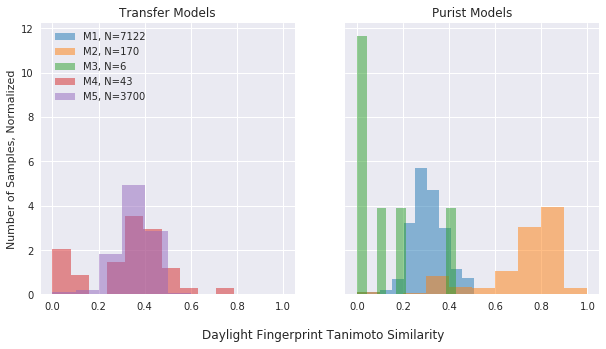

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity',size=12)

Text(-0.67,-2,'MACCS Fingerprint Tanimoto Similarity')

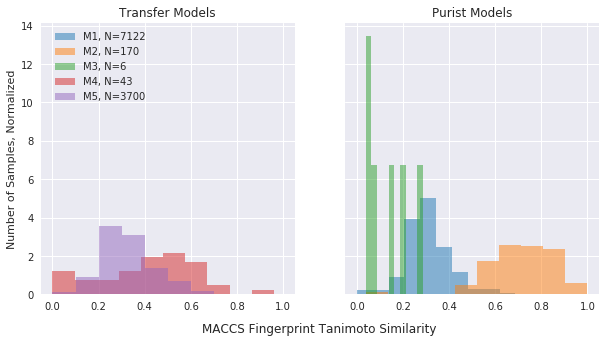

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['maccs'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'MACCS Fingerprint Tanimoto Similarity',size=12)

**But how many of these structures are relevant?**

In [40]:
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles'] if '+' in smi]    
    print('{}\t positively charged molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [smi for smi in df['smiles'] if '+' in smi]    
    ms = [smi for smi in ms if 'C+' not in smi]
    ms = [smi for smi in ms if 'c+' not in smi]
    print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df5, df, how='inner', on='smiles')['smiles']]
    print('{}\t structures shared by M5 and M{}'.format(len(ms),i+1))

6	 positively charged molecules in M1
167	 positively charged molecules in M2
0	 positively charged molecules in M3
29	 positively charged molecules in M4
1729	 positively charged molecules in M5

0	 positively charged molecules in M1 w/o C+
167	 positively charged molecules in M2 w/o C+
0	 positively charged molecules in M3 w/o C+
28	 positively charged molecules in M4 w/o C+
807	 positively charged molecules in M5 w/o C+

94	 structures shared by M5 and M1
9	 structures shared by M5 and M2
4	 structures shared by M5 and M3
11	 structures shared by M5 and M4
3700	 structures shared by M5 and M5


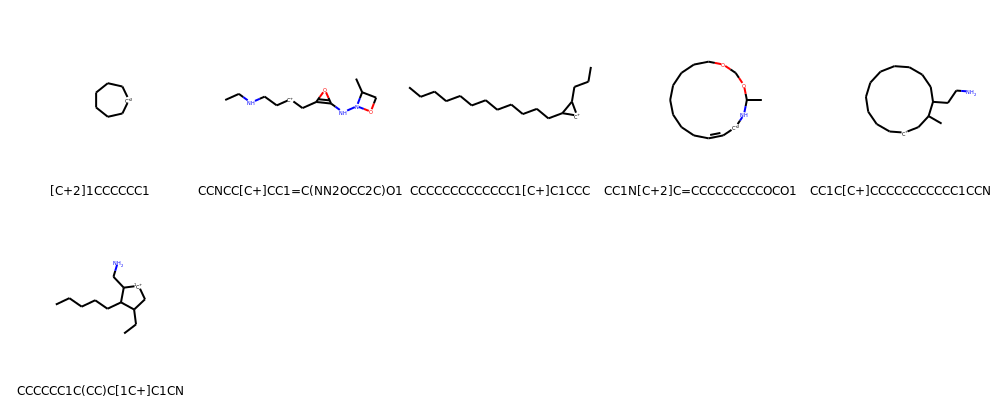

In [15]:
ms = [Chem.MolFromSmiles(smi) for smi in df1['smiles'] if '+' in smi]
Draw.MolsToGridImage(ms[:50],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])

M5 sample of + structures


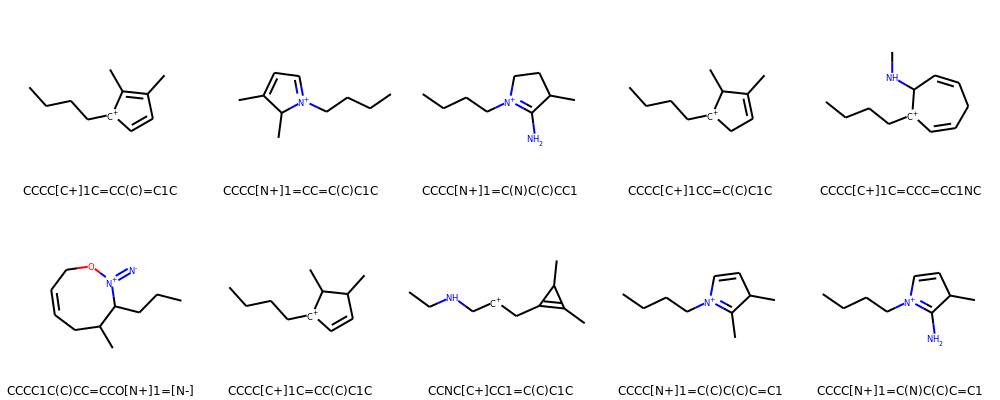

In [45]:
ms = [Chem.MolFromSmiles(smi) for smi in df5['smiles'] if '+' in smi]
print('M5 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:10]])

M2 sample of + structures


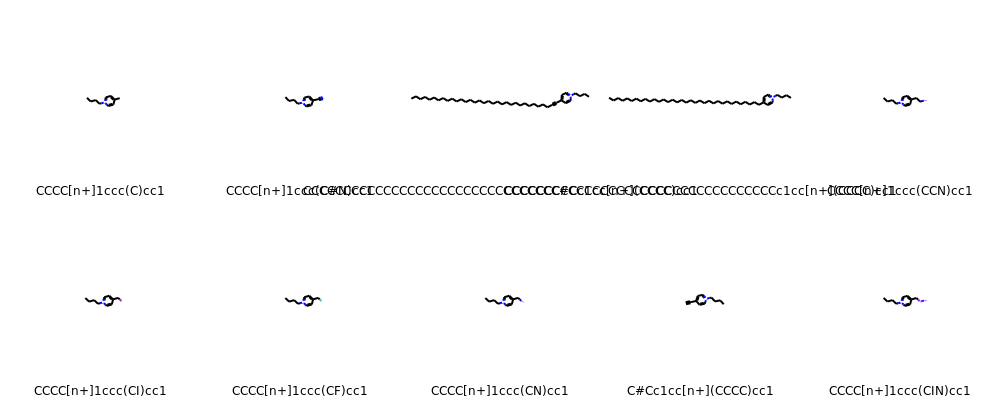

In [46]:
ms = [Chem.MolFromSmiles(smi) for smi in df2['smiles'] if '+' in smi]
print('M2 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:10]])

M4 sample of + structures


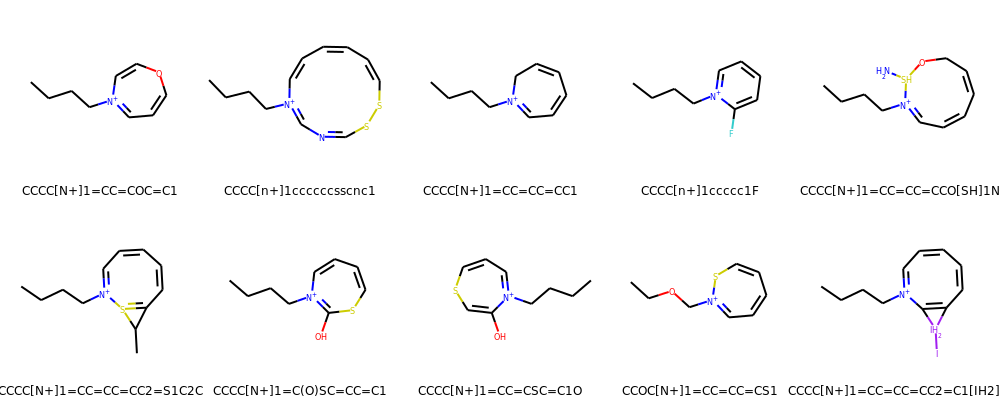

In [47]:
ms = [Chem.MolFromSmiles(smi) for smi in df4['smiles'] if '+' in smi]
print('M4 sample of + structures')
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

94 structures shared by M5 and M1


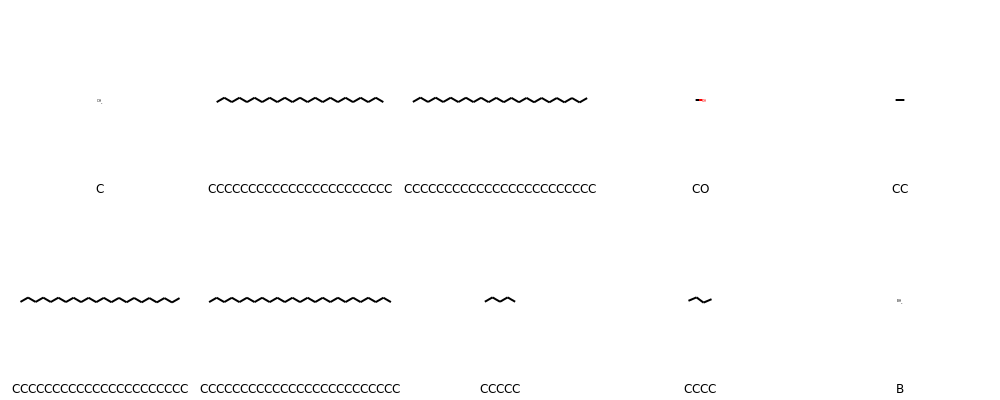

In [44]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df1, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M1'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

11 structures shared by M5 and M4


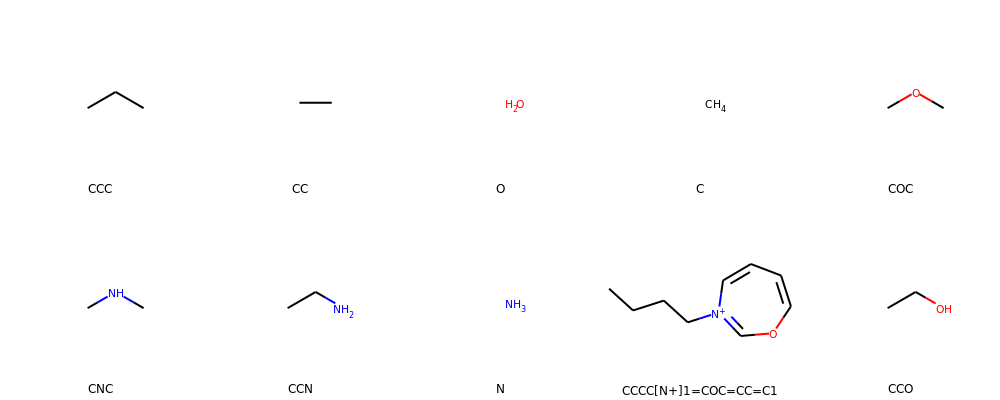

In [41]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df4, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M4'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

9 structures shared by M5 and M2


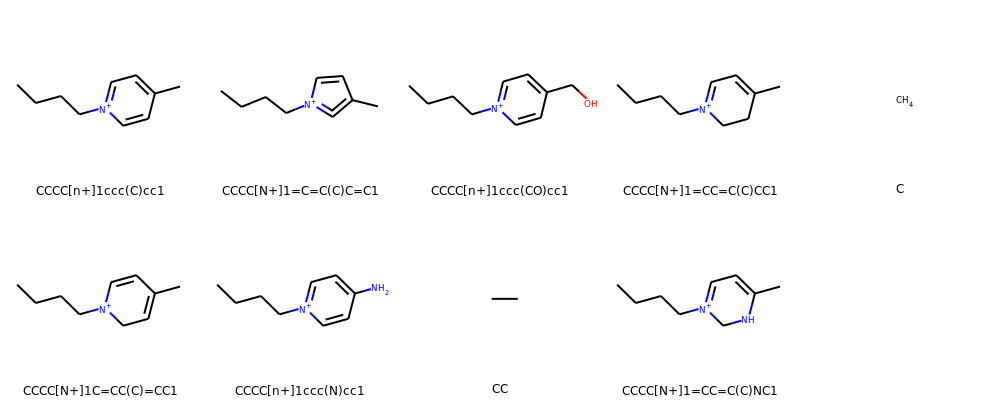

In [42]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df2, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M2'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])